# Analisi di network

**Caso studio: amicizie in social network**



*   Definizione degli utenti e delle relazioni di amicizia



In [1]:
from typing import NamedTuple

class User(NamedTuple):
    id: int
    name: str

users = [User(0, "Hero"), User(1, "Dunn"), User(2, "Sue"), User(3, "Chi"),
         User(4, "Thor"), User(5, "Clive"), User(6, "Hicks"),
         User(7, "Devin"), User(8, "Kate"), User(9, "Klein")]

friend_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
                (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]



* Amicizie inserite in un dizionario con utenti come chiave



In [2]:
from typing import Dict, List

# type alias for keeping track of Friendships
Friendships = Dict[int, List[int]]

friendships: Friendships = {user.id: [] for user in users}

for i, j in friend_pairs:
    friendships[i].append(j)
    friendships[j].append(i)



**Centralità**

Quando i dati da analizzare sono in forma di grafo (network), una nozione importante è quella di centralità, ovvero quali nodi sono centrali al grafo. Questo permette di trovare i nodi più importanti, nel caso degli utenti di un social network ad esempio, gli utenti più influenti.



**Approccio 1: *from scratch***

**Betweenness centrality**

Misura di centralità dei nodi di un network basata sul concetto di shortest path. 

I nodi più centrali sono quelli che si trovano maggiormente lungo il percorso più corto per collegare le altre coppie di nodi. 

In altre parole, dato un nodo *i* e le coppie di tutti gli altri nodi *j* e *k*, la *betweenness centrality* di *i* è calcolata come la proporzione dei percorsi più brevi da *j* a *k* che passano da *i*, per ogni coppia di *j* e *k*.





* Per costruire un modello di *betweenness centrality*, serve implementae un algoritmo shortest path. In questo caso si tratta di un algoritmo *breadth-first search*:



In [3]:
from collections import deque

Path = List[int]

def shortest_paths_from(from_user_id: int,
                        friendships: Friendships) -> Dict[int, List[Path]]:
    # A dictionary from "user_id" to *all* shortest paths to that user
    shortest_paths_to: Dict[int, List[Path]] = {from_user_id: [[]]}

    # A queue of (previous user, next user) that we need to check.
    # Starts out with all pairs (from_user, friend_of_from_user)
    frontier = deque((from_user_id, friend_id)
                     for friend_id in friendships[from_user_id])

    # Keep going until we empty the queue.
    while frontier:
        # Remove the pair that's next in the queue.
        prev_user_id, user_id = frontier.popleft()

        # Because of the way we're adding to the queue,
        # necessarily we already know some shortest paths to prev_user
        paths_to_prev_user = shortest_paths_to[prev_user_id]
        new_paths_to_user = [path + [user_id] for path in paths_to_prev_user]

        # It's possible we already know a shortest path to user_id.
        old_paths_to_user = shortest_paths_to.get(user_id, [])

        # What's the shortest path to here that we've seen so far?
        if old_paths_to_user:
            min_path_length = len(old_paths_to_user[0])
        else:
            min_path_length = float('inf')

        # Only keep paths that aren't too long and are actually new
        new_paths_to_user = [path
                             for path in new_paths_to_user
                             if len(path) <= min_path_length
                             and path not in old_paths_to_user]

        shortest_paths_to[user_id] = old_paths_to_user + new_paths_to_user

        # Add never-seen neighbors to the frontier
        frontier.extend((user_id, friend_id)
                        for friend_id in friendships[user_id]
                        if friend_id not in shortest_paths_to)

    return shortest_paths_to


In [5]:
shortest_paths = {user.id: shortest_paths_from(user.id, friendships)
                  for user in users}

betweenness_centrality = {user.id: 0.0 for user in users}

for source in users:
    for target_id, paths in shortest_paths[source.id].items():
        if source.id < target_id:      # don't double count
            num_paths = len(paths)     # how many shortest paths?
            contrib = 1 / num_paths    # contribution to centrality
            for path in paths:
                for between_id in path:
                    if between_id not in [source.id, target_id]:
                        betweenness_centrality[between_id] += contrib



*   Secondo questo modello, il nodo 5 è quello più influente.



In [14]:
betweenness_centrality

{0: 0.0,
 1: 3.5,
 2: 3.5,
 3: 18.0,
 4: 20.0,
 5: 20.5,
 6: 6.0,
 7: 6.0,
 8: 8.5,
 9: 0.0}

**Closeness centrality**

In questo modello, per ogni nodo si calcola la *lontananza*, ovvero la somma della distanza shortest path da tutti gli altri nodi.

In [15]:
def farness(user_id: int) -> float:
    """the sum of the lengths of the shortest paths to each other user"""
    return sum(len(paths[0])
               for paths in shortest_paths[user_id].values())

closeness_centrality = {user.id: 1 / farness(user.id) for user in users}



*   In questo modello, i nodi 4 e 5 sono i più influenti



In [18]:
closeness_centrality

{0: 0.029411764705882353,
 1: 0.037037037037037035,
 2: 0.037037037037037035,
 3: 0.045454545454545456,
 4: 0.05,
 5: 0.05,
 6: 0.041666666666666664,
 7: 0.041666666666666664,
 8: 0.03571428571428571,
 9: 0.027777777777777776}

**Centralità degli autovalori**

Calcolare gli *shortest path* per tutti i nodi è molto oneroso specialmente per network molto grandi. Per questo, si tende a lavorare con i grafi in forma matriciale, ovvero calcolando le matrici di adiacenza. Le operazioni con matrici sono estremamente più efficienti.



*   Per lavorare con le matrici, è prima necessario definire le operazioni matriciali moltiplicazione matrice * matrice e moltiplicazione matrice * vettore



In [52]:
from linear_algebra import Matrix, make_matrix, shape

def matrix_times_matrix(m1, m2):
    nr1, nc1 = shape(m1)
    nr2, nc2 = shape(m2)
    assert nc1 == nr2, "must have (# of columns in m1) == (# of rows in m2)"

    def entry_fn(i, j):
        """dot product of i-th row of m1 with j-th column of m2"""
        return sum(m1[i][k] * m2[k][j] for k in range(nc1))

    return make_matrix(nr1, nc2, entry_fn)

from linear_algebra import Vector, dot

def matrix_times_vector(m: Matrix, v: Vector) -> Vector:
    nr, nc = shape(m)
    n = len(v)
    assert nc == n, "must have (# of cols in m) == (# of elements in v)"

    return [dot(row, v) for row in m]  # output has length nr



*   Possiamo ora creare la matrice di adiacenza, che mostra in forma matriciale le connessioni tra i nodi.



In [51]:
def entry_fn(i, j):
    return 1 if (i, j) in friend_pairs or (j, i) in friend_pairs else 0

n = len(users)
adjacency_matrix = make_matrix(n, n, entry_fn)



*   Funzione per trovare gli autovalori di una matrice





In [50]:
from typing import Tuple
import random
from linear_algebra import magnitude, distance

def find_eigenvector(m, tolerance: float = 0.00001):
    guess = [random.random() for _ in m]

    while True:
        result = matrix_times_vector(m, guess)    # transform guess
        norm = magnitude(result)                  # compute norm
        next_guess = [x / norm for x in result]   # rescale

        if distance(guess, next_guess) < tolerance:
            # convergence so return (eigenvector, eigenvalue)
            return next_guess, norm

        guess = next_guess

*   L'autovettore viene utilizzato come nozione di centralità



In [23]:
eigenvector_centralities, _ = find_eigenvector(adjacency_matrix)



* Secondo il modello degli autovettori, i nodi più influenti nel network sono l'1 e il 2



In [24]:
eigenvector_centralities

[0.3857806721154508,
 0.5147894502571881,
 0.5147894502571881,
 0.4733139688741159,
 0.23360776397765168,
 0.15015009983906058,
 0.08355229488423929,
 0.08355229488423929,
 0.07284420923008686,
 0.027293095226940598]

**Approccio 1: *NetworkX***

In [25]:
import networkx as nx



*   NetworkX è un modulo Python che permette di definire, visualizzare ed eseguire operazioni su network (grafi), in maniera intuitiva.





*   Creazione del grafo precedente con le strutture di NetworkX


In [37]:
network = nx.Graph()
for id, name in users:
  network.add_node(id)
for u1, u2 in friend_pairs:
  network.add_edge(u1, u2)

In [38]:
network.edges

EdgeView([(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)])



* Visualizzazione del grafo



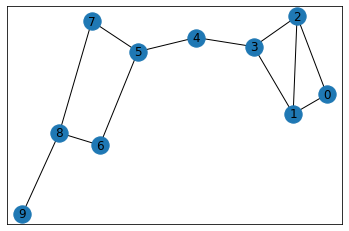

In [48]:
nx.draw_networkx(network)



* Calcolo delle 3 centralità viste in precedenza, i valori assoluti sono diversi ma le proporzioni le stesse.



1.   Betweenness





In [44]:
nx.betweenness_centrality(network)

{0: 0.0,
 1: 0.09722222222222221,
 2: 0.09722222222222221,
 3: 0.5,
 4: 0.5555555555555556,
 5: 0.5694444444444444,
 6: 0.16666666666666666,
 7: 0.16666666666666666,
 8: 0.2361111111111111,
 9: 0.0}

2. Closeness

In [45]:
nx.closeness_centrality(network)

{0: 0.2647058823529412,
 1: 0.3333333333333333,
 2: 0.3333333333333333,
 3: 0.4090909090909091,
 4: 0.45,
 5: 0.45,
 6: 0.375,
 7: 0.375,
 8: 0.32142857142857145,
 9: 0.25}

3. Autovalori

In [49]:
nx.eigenvector_centrality(network)

{0: 0.3857774175578156,
 1: 0.5147865897889067,
 2: 0.5147865897889067,
 3: 0.47331198342542713,
 4: 0.2336132555988402,
 5: 0.15015820248530365,
 6: 0.08356344040001874,
 7: 0.08356344040001874,
 8: 0.07285279920861787,
 9: 0.027298680091063284}